# Lotka Volterra UPINN

In [ ]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pysindy as ps
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from UPINN import UPINN
from DataGenerators import sample_collocation_points
from Architectures import FNN, ResNet
from scripts.LotkaVolterra.LotkaVolterraData import LVData
from Utils import SINDy_sklearn

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

In [100]:
# Data
alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
X0 = torch.tensor([1.0, 1.0]).reshape(-1, 2)

Nd = 5 # Number of data points

time_int = [0, 25]
spacing = (time_int[1] - time_int[0]) / Nd

data_time_points = np.linspace(time_int[0]+spacing, time_int[1], Nd)

data = LVData(X0, alpha, beta, gamma, delta, time_int, time_points=data_time_points)

td = data.td
Xd = data.Xd

In [101]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0

In [102]:
# Collocation points
N_coll = 1000
Xc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

### Known system $N_K$

Assume that $\gamma x y$ is not known, and we want to learn it from data.

In [103]:
class SparseLV(torch.nn.Module):
    
    def __init__(self, params):
        super(SparseLV, self).__init__()
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.delta = params['delta']
        self.gamma = params['gamma']

    def forward(self, z, U):

        dUdt = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        return torch.stack([
            dUdt[:, 0] - alpha*U[:, 0], # + beta*U[:, 0]*U[:, 1],
            dUdt[:, 1] + delta*U[:, 1] # - gamma*U[:, 0]*U[:, 1] # <-- Estimate this
        ], dim=-1)


params = dict(
    alpha=alpha,
    beta=beta,
    delta=delta,
    gamma=gamma
)

N = SparseLV(params)

### Problem specific UPINN functions

In [104]:
class LV_UPINN(UPINN):

    # def get_loss(self):
    #     bc_loss = self.bc_loss()
    #     data_loss = self.data_loss()
    #     pde_loss = self.pde_loss()
    #     lambdas = SoftAdapt(**self.softadapt_kwargs)(torch.tensor([bc_loss, data_loss, pde_loss]))
    #     loss = lambdas[0]*bc_loss + lambdas[1]*data_loss + lambdas[2]*pde_loss

    #     return loss, bc_loss, data_loss, pde_loss

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.nn.MSELoss()(u_pred, data.X_full)
    

    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            t_plot = data.t_full
            x_true = data.X_full[:, 0:1]
            y_true = data.X_full[:, 1:2]

            u_pred = self.u(t_plot)
            F_pred = self.F(self.F_input(t_plot, u_pred))

            x_pred = u_pred[:, 0]
            y_pred = u_pred[:, 1]

            fig, ax = plt.subplots(2, 1, figsize=(8, 6))
            plt.subplot(2, 1, 1)
            plt.plot(td, Xd[:, 0], 'rx')
            plt.plot(td, Xd[:, 1], 'bx')
            plt.plot(t_plot, x_pred, 'r', label='Predator')
            plt.plot(t_plot, y_pred, 'b', label='Prey')
            plt.plot(t_plot, x_true, 'r--')
            plt.plot(t_plot, y_true, 'b--')
            plt.xlabel('t')
            plt.legend()
            
            plt.subplot(2, 1, 2)
            plt.plot(t_plot, F_pred[:, 0], 'r', label='Predator residual')
            plt.plot(t_plot, F_pred[:, 1], 'b', label='Prey residual')
            plt.plot(t_plot, beta*x_true*y_true, 'r--')
            plt.plot(t_plot, -gamma*x_true*y_true, 'b--')
            plt.xlabel('t')
            plt.legend()

            if save is not None:
                plt.savefig(save, dpi=600)

            plt.show()


### Setup UPINN

In [105]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.SiLU(),
)
F = FNN(
    dims=[2, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

In [106]:
upinn = LV_UPINN(u, N, F, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=Xc)

[Info]: Initializing UPINN model


### Train

In [107]:
adamw = torch.optim.AdamW(upinn.parameters(), lr=1e-3, weight_decay=1e-4)
upinn.optimizer = adamw
upinn.train_loop(1000)


lbfgs = torch.optim.LBFGS(upinn.parameters(), lr=0.1)
upinn.softadapt_kwargs = dict(beta=0.2)
upinn.softadapt_interval = 10
upinn.optimizer = lbfgs
upinn.train_loop(50)

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 84.07 epoch/s, loss=5.41e-02, bc_loss=4.29e-06, data_loss=5.17e-02, pde_loss=2.37e-03]


[Info]: Training 50 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 50/50 [00:35<00:00,  1.40 epoch/s, loss=1.31e-03, bc_loss=1.24e-06, data_loss=1.12e-03, pde_loss=2.82e-03]


In [109]:
# lbfgs = torch.optim.LBFGS(upinn.parameters(), lr=1)
upinn.train_loop(200)

[Info]: Training 200 epoch(s) on cuda using LBFGS optimizer.


[CUDA]:   0%|          | 0/200 [00:00<?, ? epoch/s]

[CUDA]: 100%|██████████| 200/200 [02:38<00:00,  1.26 epoch/s, loss=2.86e-05, bc_loss=6.76e-08, data_loss=9.30e-07, pde_loss=8.49e-05]


In [77]:
path = 'models'
name = 'lv_upinn_10_datapoints_KAN_FNN'
upinn.save(name, path)

[Info]: Successfully saved total model with name lv_upinn_10_datapoints_KAN_FNN at models


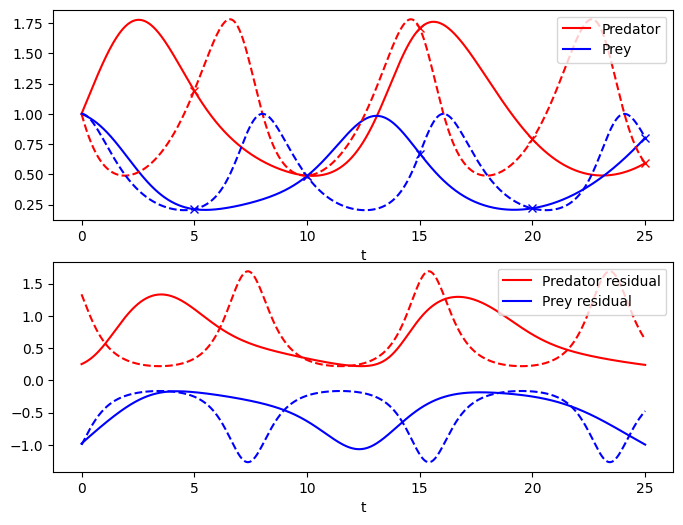

In [110]:
upinn.plot()

In [9]:
# upinn.save('lv_sindy', 'models')
upinn.load('lv_sindy', 'models')

In [111]:
# Generate data from the solution network
t = data.t_full
X = upinn.u(t)
X_dot = upinn.F(upinn.F_input(None, X))
t = t.detach().numpy()
X = X.detach().numpy()
X_dot = X_dot.detach().numpy()

In [112]:
# Hyperparameter tuning using Crossvalidation with TimeSeriesSplit
model = SINDy_sklearn(feature_names=['x', 'y'], feature_library=ps.PolynomialLibrary(degree=2))
paramgrid = dict(optimizer__threshold=np.linspace(0.01, 1.0, 100))

cv_folds = TimeSeriesSplit(n_splits=10)
model_selector = GridSearchCV(model, param_grid=paramgrid, cv=cv_folds, n_jobs=-1)
wrapped_input = np.concatenate([t, X], axis=1)
model_selector.fit(wrapped_input, X_dot)
best_model = model_selector.best_estimator_

best_model.print()

(x)' = 1.063 x + 0.044 y + -0.740 x y + -0.117 y^2
(y)' = 0.156 1 + -0.178 x + -1.927 y + 0.104 x^2 + 0.463 x y + 0.397 y^2
